In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import tensorflow as tf

from tqdm import tqdm_notebook
from scipy.spatial.distance import hamming, cosine

%matplotlib inline

/media/Data/Programs/Image_search_engine_tutorial/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/Data/Programs/Image_search_engine_tutorial/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/Data/Programs/Image_search_engine_tutorial/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

## Dataset Utils and preprocessing

In [2]:
def image_loader(image_path, image_size):
    '''
    Load an image from disk.
    
    :param image_path: String, path to the image
    :param image_size: tuple, size of an output image Example image_size=(32, 32)
    '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # converts image from VGA format to RGB
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    return image

In [3]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    '''
    Loads images and labels from dataset folder.
    
    :param dataset_path: String, path to the train/test dataset folder
    :param labels_file_path: String, path to the .txt file where classes names are written
    :param image_size: tuple, single image size
    :param image_paths_pickle: String, name of a pickle file where all image paths will be saved
    '''  
    with open(labels_file_path, "r") as f:
        classes = f.read().split("\n")[:-1]
        
    images = []
    labels = []
    image_paths = []
    
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path, image_name)
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)
            
            # each image name has its label in the name, we are extracting these labels
            for idx in range(len(classes)):
                if classes[idx] in image_name: 
                    labels.append(idx)   
        except:
            pass
    
    with open(image_paths_pickle + ".pickle", "wb") as f:
        pickle.dump(image_paths, f)
    
    assert len(images) == len(labels)
    return np.array(images), np.array(labels)

## Utils function

In [4]:
def cosine_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates cosine distance between query image (vector) and all training set images (vectors).
    
    :param training_set_vectors: numpy Matrix, vectors for all images in the training set
    :param query_vector: numpy vector, query image (new image) vector
    :param top_n: integer, number of closest images to return
    '''
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(cosine(training_set_vectors[i], query_vector[0]))
        
    return np.argsort(distances)[:top_n]

In [5]:
def hamming_distance(training_set_vectors, query_vector, top_n=50):
    '''
    Calculates hamming distance between query image (vector) and all training set images (vectors).
    
    :param training_set_vectors: numpy Matrix, vectors for all images in the training set
    :param query_vector: numpy vector, query image (new image) vector
    :param top_n: integer, number of closest images to return
    '''
    
    distances = []
    
    for i in range(len(training_set_vectors)):
        distances.append(hamming(training_set_vectors[i], query_vector[0]))
        
    return np.argsort(distances)[:top_n]

In [6]:
def sparse_accuracy(true_labels, predicted_labels):
    '''
    Calculates accuracy of a model based on softmax outputs.
    
    :param true_labels: numpy array, real labels of each sample. Example: [1, 2, 1, 0, 0]
    :param predicted_labels: numpy matrix, softmax probabilities. Example: [[0.2, 0.1, 0.7], [0.9, 0.05, 0.05]]
    '''
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    
    for i in range(len(true_labels)):
        
        if np.argmax(predicted_labels[i]) == true_labels[i]:
            correct = correct + 1
            
    return correct / len(true_labels)

## Model Utils

In [7]:
def model_inputs(image_size):
    '''
    Defines CNN inputs (placeholders).
    
    :param image_size: tuple, (height, width) of an image
    '''
    inputs = tf.placeholder(dtype=tf.float32, shape=[None, image_size[0], image_size[1], 3], name='images')
    targets = tf.placeholder(dtype=tf.int32, shape=[None], name='targets')
    dropout_rate = tf.placeholder(dtype=tf.float32, name='dropout_rate')
    return inputs, targets, dropout_rate

In [8]:
def conv_block(inputs,
               number_of_filters,
               kernel_size, strides=(1, 1),
               padding='SAME',
               activation=tf.nn.relu,
               max_pool=True,
               batch_norm=True):
    '''
    Defines convolutional block layer.
    
    :param inputs: data from previous layer
    :param number_of_filters: integer, number of conv filters
    :param kernel_size: tuple, size of conv layer kernel
    :param padding: string, type of padding technique: SAME or VALID
    :param activation: tf.object, activation function used on the layer
    :param max_pool: boolean, if true the conv block will use max_pool
    :param batch_norm: boolean, if true the conv block will use batch normalization
    '''
    
    conv_features = layer = tf.layers.Conv2D(filters=number_of_filters,
                                             kernel_size=kernel_size,
                                             strides=strides,
                                             padding=padding,
                                             activation=activation)(inputs)
    if max_pool:
        layer = tf.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='SAME')(layer)
    if batch_norm:
        layer = tf.layers.BatchNormalization()(layer)
    
    return layer, conv_features

In [9]:
def dense_block(inputs,
                units,
                activation=tf.nn.relu,
                dropout_rate=None,
                batch_norm=True):
    '''
    Defines dense block layer.
    
    :param inputs: data from the previous layer
    :param units: integer, number of neurons/units for a dense layer
    :param activation: tf.object, activation function used on the layer
    :param dropout_rate: dropout rate used in this dense block
    :param batch_norm: boolean, if true the dense block will use batch normalization
    '''
    
    dense_features = layer = tf.layers.Dense(units=units, activation=activation)(inputs)
    if dropout_rate is not None:
        layer = tf.layers.Dropout(rate=dropout_rate)(layer)
    if batch_norm:
        layer = tf.layers.BatchNormalization()(layer)
    
    return layer, dense_features

In [10]:
def opt_loss(logits,
             targets,
             learning_rate):
    '''
    Defines model's optimizer and loss functions.
    
    :param logits: pre-activated model outputs
    :param targets: true labels for each input sample
    :param learning_rate: learning rate
    '''
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return loss, optimizer

In [11]:
class ImageSearchModel(object):
    
    def __init__(self,
                 learning_rate,
                 image_size,
                 number_of_classes=10):
        '''
        Defines CNN model.
        
        :param learning_rate: learning_rate
        :param image_size: tuple, (height, width) of an image
        :param number_of_classes: integer, number of classes in dataset
        '''
        
        tf.reset_default_graph()
        
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        
        normalized_images = tf.layers.BatchNormalization()(self.inputs)
        
        #conv block 1
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images,
                                                        number_of_filters=64,
                                                        kernel_size=(3, 3),
                                                        strides=(1, 1),
                                                        padding='SAME',
                                                        activation=tf.nn.relu,
                                                        max_pool=True,
                                                        batch_norm=True)
        
        #conv block 2
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1,
                                                        number_of_filters=128,
                                                        kernel_size=(3, 3),
                                                        strides=(1, 1),
                                                        padding='SAME',
                                                        activation=tf.nn.relu,
                                                        max_pool=True,
                                                        batch_norm=True)
        
        #conv block 3
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2,
                                                        number_of_filters=256,
                                                        kernel_size=(5, 5),
                                                        strides=(1, 1),
                                                        padding='SAME',
                                                        activation=tf.nn.relu,
                                                        max_pool=True,
                                                        batch_norm=True)
        
        #conv block 4
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3,
                                                        number_of_filters=512,
                                                        kernel_size=(5, 5),
                                                        strides=(1, 1),
                                                        padding='SAME',
                                                        activation=tf.nn.relu,
                                                        max_pool=True,
                                                        batch_norm=True)
        
        #flattening
        flat_layer = tf.layers.Flatten()(conv_block_4)
        
        #Dense block 1
        dense_block_1, self.dense_1_features = dense_block(flat_layer,
                                                           units=128,
                                                           activation=tf.nn.relu,
                                                           dropout_rate=self.dropout_rate,
                                                           batch_norm=True)
        
        #Dense block 2
        dense_block_2, self.dense_2_features = dense_block(dense_block_1,
                                                           units=256,
                                                           activation=tf.nn.relu,
                                                           dropout_rate=self.dropout_rate,
                                                           batch_norm=True)
        
        #Dense block 3
        dense_block_3, self.dense_3_features = dense_block(dense_block_2,
                                                           units=512,
                                                           activation=tf.nn.relu,
                                                           dropout_rate=self.dropout_rate,
                                                           batch_norm=True)
        
        #Dense block 4
        dense_block_4, self.dense_4_features = dense_block(dense_block_3,
                                                           units=1024,
                                                           activation=tf.nn.relu,
                                                           dropout_rate=self.dropout_rate,
                                                           batch_norm=True)
        
        logits = tf.layers.Dense(units=number_of_classes, activation=None)(dense_block_4)
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.opt = opt_loss(logits=logits,
                                       targets=self.targets,
                                       learning_rate=learning_rate)

## Training loop - training the model

In [12]:
def train(model,
          epochs,
          drop_rate,
          batch_size,
          data,
          save_dir, 
          saver_delta=0.15):
    '''
    The core training function, use this function to train a model.
    
    :param model: CNN model
    :param epochs: integer, number of epochs
    :param drop_rate: float, dropout_rate
    :param batch_size: integer, number of samples to put through the model at once
    :param data: tuple, train-test data Example (X_train, y_train, X_test, y_test)
    :param save_dir: String, path to a folder where model checkpoints will be saved
    :param saver_delta: float, used to prevent overfitted model to be saved
    '''
    
    X_train, y_train, X_val, y_val = data
    
    # Tensorflow Session
    config = tf.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 0.2
    
    session = tf.Session(config=config)
    session.run(tf.global_variables_initializer()) # Initializing global variables of the Tensorflow session
    
    # Defining a Tensorflow Saver object
    saver = tf.train.Saver()
    
    best_val_accuracy = 0
    
    # Training loop
    for epoch in range(epochs):
        
        train_accuracy = []
        train_loss = []
        
        for ii in tqdm_notebook(range(len(X_train) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            
            feed_dict = {model.inputs: X_batch,
                         model.targets: y_batch,
                         model.dropout_rate: drop_rate}
            
            _, t_loss, preds_t = session.run([model.opt, model.loss, model.predictions], feed_dict=feed_dict)
            
            train_accuracy.append(sparse_accuracy(y_batch, preds_t))
            train_loss.append(t_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),
              " | Training accuracy: {}".format(np.mean(train_accuracy)),
              " | Training loss: {}".format(np.mean(train_loss)))
            
        # Evaluating on Validation set
        val_accuracy = []
        val_loss = []
            
        for ii in tqdm_notebook(range(len(X_val) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_val[start_id:end_id]
            y_batch = y_val[start_id:end_id]
            
            feed_dict = {model.inputs: X_batch,
                         model.targets: y_batch,
                         model.dropout_rate: 0.0}
            
            v_loss, preds_val = session.run([model.loss, model.predictions], feed_dict=feed_dict)
            
            val_accuracy.append(sparse_accuracy(y_batch, preds_val))
            val_loss.append(v_loss)
            
        print("Validation accuracy: {0}, Validation loss: {1}".format(np.mean(val_accuracy), np.mean(val_loss)))
        
        # Saving the model
        if np.mean(train_accuracy) > np.mean(val_accuracy):
            if np.abs(np.mean(train_accuracy) - np.mean(val_accuracy)) <= saver_delta:
                if np.mean(val_accuracy) >= best_val_accuracy:
                    best_test_accuracy = np.mean(val_accuracy)
                    saver.save(session, "{}/model_epochs_{}.ckp".format(save_dir, epoch))
        
    session.close()

## Setting hyperparameters and training the model

In [13]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_probs = 0.6
image_size = (32, 32)

In [14]:
X_train, y_train = dataset_preprocessing("../data/train/", "../data/labels.txt", image_size, "train_images_pickle")

In [15]:
X_train.shape

(50000, 32, 32, 3)

In [16]:
X_test, y_test = dataset_preprocessing("../data/test/", "../data/labels.txt", image_size, "test_images_pickle")

In [17]:
X_test.shape

(10000, 32, 32, 3)

In [18]:
model = ImageSearchModel(learning_rate, image_size)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [19]:
data = (X_train, y_train, X_test, y_test)

In [20]:
train(model, epochs, dropout_probs, batch_size, data, "saver")


Epoch: 0/20  | Training accuracy: 0.3699519230769231  | Training loss: 1.8042176961898804



Validation accuracy: 0.500801282051282, Validation loss: 1.3739855289459229



Epoch: 1/20  | Training accuracy: 0.5511217948717949  | Training loss: 1.251085638999939



Validation accuracy: 0.589042467948718, Validation loss: 1.149598479270935



Epoch: 2/20  | Training accuracy: 0.6285456730769231  | Training loss: 1.0502997636795044



Validation accuracy: 0.6263020833333334, Validation loss: 1.0468027591705322



Epoch: 3/20  | Training accuracy: 0.6843149038461539  | Training loss: 0.9053775072097778



Validation accuracy: 0.6109775641025641, Validation loss: 1.118196964263916



Epoch: 4/20  | Training accuracy: 0.7182491987179487  | Training loss: 0.8088923692703247



Validation accuracy: 0.6292067307692307, Validation loss: 1.1099637746810913



Epoch: 5/20  | Training accuracy: 0.7486177884615385  | Training loss: 0.7264975309371948



Validation accuracy: 0.6286057692307693, Validation loss: 1.194807529449463



Epoch: 6/20  | Training accuracy: 0.7832932692307693  | Training loss: 0.6323353052139282



Validation accuracy: 0.6435296474358975, Validation loss: 1.2030742168426514



Epoch: 7/20  | Training accuracy: 0.8045472756410257  | Training loss: 0.5706788897514343



Validation accuracy: 0.6470352564102564, Validation loss: 1.3292206525802612



Epoch: 8/20  | Training accuracy: 0.8330328525641025  | Training loss: 0.4859983026981354



Validation accuracy: 0.6207932692307693, Validation loss: 1.4260838031768799



Epoch: 9/20  | Training accuracy: 0.8532051282051282  | Training loss: 0.4333520233631134



Validation accuracy: 0.5925480769230769, Validation loss: 1.6087126731872559



Epoch: 10/20  | Training accuracy: 0.8672676282051283  | Training loss: 0.39267006516456604



Validation accuracy: 0.6350160256410257, Validation loss: 1.4938769340515137



Epoch: 11/20  | Training accuracy: 0.8872596153846154  | Training loss: 0.3347320556640625



Validation accuracy: 0.643729967948718, Validation loss: 1.5647339820861816



Epoch: 12/20  | Training accuracy: 0.9020032051282051  | Training loss: 0.29519620537757874



Validation accuracy: 0.6496394230769231, Validation loss: 1.6389082670211792



Epoch: 13/20  | Training accuracy: 0.9105769230769231  | Training loss: 0.2709759771823883



Validation accuracy: 0.6403245192307693, Validation loss: 1.6722333431243896



Epoch: 14/20  | Training accuracy: 0.9205528846153846  | Training loss: 0.23839306831359863



Validation accuracy: 0.6465344551282052, Validation loss: 1.7976038455963135



Epoch: 15/20  | Training accuracy: 0.9303485576923077  | Training loss: 0.20641756057739258



Validation accuracy: 0.651542467948718, Validation loss: 1.7820467948913574



Epoch: 16/20  | Training accuracy: 0.9421073717948718  | Training loss: 0.17469149827957153



Validation accuracy: 0.6468349358974359, Validation loss: 1.8911465406417847



Epoch: 17/20  | Training accuracy: 0.9479767628205128  | Training loss: 0.15813511610031128



Validation accuracy: 0.6428285256410257, Validation loss: 1.8642843961715698



Epoch: 18/20  | Training accuracy: 0.9542467948717949  | Training loss: 0.13948649168014526



Validation accuracy: 0.6346153846153846, Validation loss: 1.89079749584198



Epoch: 19/20  | Training accuracy: 0.9546674679487179  | Training loss: 0.14020977914333344



Validation accuracy: 0.6428285256410257, Validation loss: 1.9264757633209229


In [21]:
def create_training_set_vectors(model, 
                                X_train,
                                y_train,
                                batch_size,
                                checkpoint_path,
                                image_size,
                                distance="hamming"):
    '''
    Creates training set vectors and saves them in a pickle file.
    
    :param model: CNN model
    :param X_train: numpy array, loaded training set images
    :param y_train: numpy array, loaded training set labels
    :param batch_size: integer, number of samples to put through the model at once
    :param checkpoint_path: String, path to model checkpoint
    :param image_size: tuple, single image (height, width)
    :param distance: String, type of distance metric to be used, 
                             this parameter is used to choose a way how to prepare and save training set vectors
    '''
    
    config = tf.ConfigProto() # configuring the tensorflow session
    config.gpu_options.per_process_gpu_memory_fraction = 0.2 # for a gpu session we have to configure the percentage of gpu memory tensorflow may eat up or else we might run out of memory on the gpu
    session = tf.Session(config=config)
    session.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver()
    saver.restore(session, checkpoint_path)
    
    dense_2_features = []
    dense_4_features = []
    
    for ii in tqdm_notebook(range(len(X_train) // batch_size)):
        start_id = ii * batch_size
        end_id = start_id + batch_size
        
        X_batch = X_train[start_id:end_id]
        
        feed_dict = {model.inputs: X_batch,
                     model.dropout_rate: 0.0}
        
        dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
        
        dense_2_features.append(dense_2)
        dense_4_features.append(dense_4)
        
    dense_2_features = np.vstack(dense_2_features)
    dense_4_features = np.vstack(dense_4_features)
    
    if distance == 'hamming':
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        
        with open("hamming_train_vectors.pickle", "wb") as f:
            pickle.dump(training_vectors, f)
    
    if distance == "cosine":
        training_vectors = np.hstack((dense_2_features, dense_4_features))
        with open("cosine_train_vectors.pickle", "wb") as f:
            pickle.dump(training_vectors, f)      

In [22]:
model = ImageSearchModel(learning_rate, image_size)

In [26]:
create_training_set_vectors(model, X_train, y_train, batch_size, "saver/model_epochs_6.ckp", image_size)

INFO:tensorflow:Restoring parameters from saver/model_epochs_6.ckp


In [35]:
def simple_inference(model,
                     session,
                     train_set_vectors,
                     uploaded_image_path,
                     image_size,
                     distance="hamming"):
    '''
    Doing simple inference for single uploaded image.
    
    :param model: CNN model
    :param session: tf.Session, restored session object
    :param train_set_vectors: loaded training set vectors
    :param uploaded_image_path: String, path to the uploaded image
    :param image_size: tuple, single image (height, width)
    :param distance: String, type of distance to be used
                             this parameter is used to choose a way to prepare vectors
    '''
    
    image = image_loader(uploaded_image_path, image_size)
    feed_dict = {model.inputs: [image],
                 model.dropout_rate: 0.0}
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features],
                                                     feed_dict=feed_dict)
    
    closest_ids = None
    
    if distance == "hamming":
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
    elif distance == "cosine":
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids
        

## Pipeline test

### Define session and model

In [28]:
model = ImageSearchModel(learning_rate, image_size)

config = tf.ConfigProto() # configuring the tensorflow session
config.gpu_options.per_process_gpu_memory_fraction = 0.2 # for a gpu session we have to configure the percentage of gpu memory tensorflow may eat up or else we might run out of memory on the gpu
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

### Restore session

In [29]:
saver = tf.train.Saver()
saver.restore(session, "saver/model_epochs_6.ckp")

INFO:tensorflow:Restoring parameters from saver/model_epochs_6.ckp


### Load training set image paths

In [30]:
with open("train_images_pickle.pickle", "rb") as f:
    train_image_paths = pickle.load(f)

In [31]:
train_image_paths[:10]

['cifar/train/0_frog.png',
 'cifar/train/10000_automobile.png',
 'cifar/train/10001_frog.png',
 'cifar/train/10002_frog.png',
 'cifar/train/10003_ship.png',
 'cifar/train/10004_ship.png',
 'cifar/train/10005_cat.png',
 'cifar/train/10006_deer.png',
 'cifar/train/10007_frog.png',
 'cifar/train/10008_airplane.png']

### Load training set vectors

In [32]:
with open("hamming_train_vectors.pickle", "rb") as f:
    train_set_vectors = pickle.load(f)

In [33]:
test_image = "../data/test/1052_airplane.png"

In [36]:
result_ids = simple_inference(model, session, train_set_vectors, test_image, image_size, distance="hamming")

## Showing Images

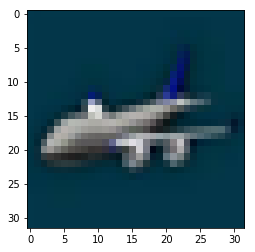

In [37]:
plt.imshow(image_loader(test_image, image_size))

### Loading found similar images

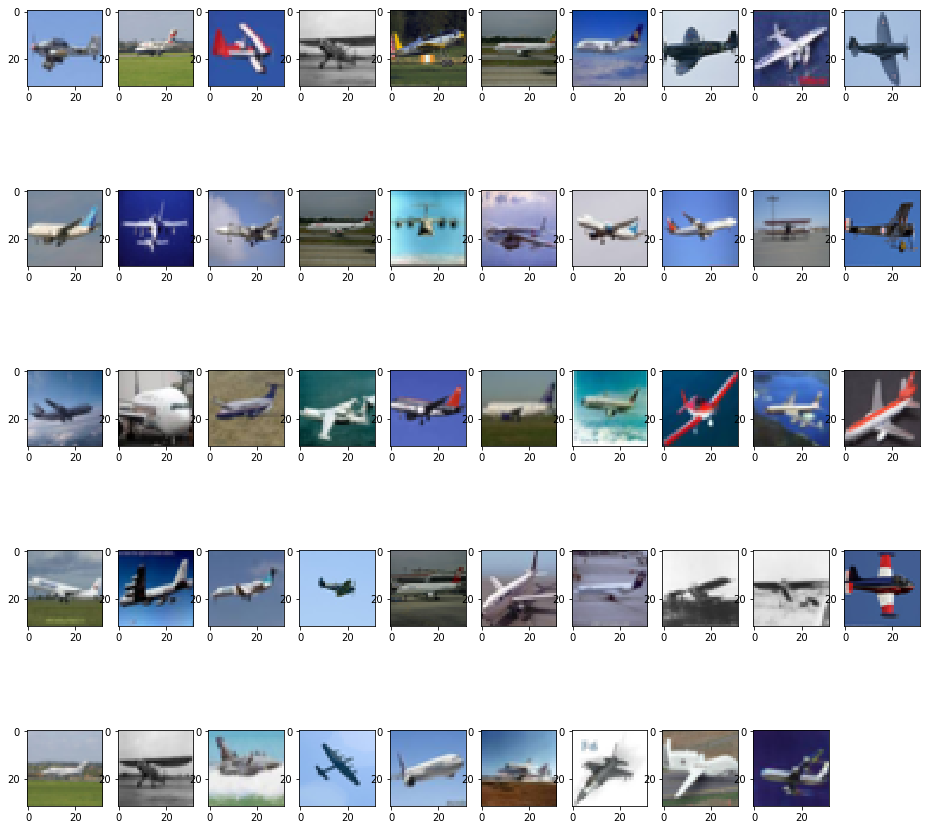

In [38]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 10
rows = 5
for i in range(1, columns*rows + 1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
    except:
        pass
plt.show()